In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os, json, random
import os
from torchvision.utils import save_image

In [ ]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval().cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [ ]:
dataset_path = "/content/drive/MyDrive/TestDataSet"

test_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
json_path = "/content/drive/MyDrive/TestDataSet/labels_list.json"
with open(json_path, "r") as f:
    index_map = json.load(f)

imagenet_labels = {i: int(entry.split(":")[0]) for i, entry in enumerate(index_map)}

In [ ]:
def evaluate_model(model, dataloader, imagenet_labels):
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            true_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()

            top1_correct += (top5_preds[:, 0] == true_labels).sum().item()
            top5_correct += sum([true_labels[i] in top5_preds[i] for i in range(len(labels))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

In [ ]:
evaluate_model(model, test_loader, imagenet_labels)

100%|██████████| 16/16 [03:08<00:00, 11.81s/it]

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


In [ ]:
def evaluate_adv(model, adv_images, dataloader, imagenet_labels, label="ADV"):
    top1_correct = 0
    top5_correct = 0
    total = 0
    idx = 0

    with torch.no_grad():
        for _, labels in dataloader:
            true_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
            batch_size = len(labels)

            inputs = torch.stack(adv_images[idx:idx + batch_size]).cuda()
            outputs = model(inputs)
            _, top5_preds = outputs.topk(5, dim=1)

            top1_correct += (top5_preds[:, 0] == true_labels).sum().item()
            top5_correct += sum([true_labels[i] in top5_preds[i] for i in range(batch_size)])
            total += batch_size
            idx += batch_size

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"[{label}] Top-1: {top1_acc:.2f}%, Top-5: {top5_acc:.2f}%")

In [ ]:
def show_adversarial_examples(loader, adversarial_tensor, count=5, title="Attack Comparison"):
    orig_images, _ = next(iter(loader))
    plt.figure(figsize=(15, 4))

    for i in range(count):
        orig = orig_images[i].permute(1, 2, 0).cpu().numpy()
        adv = adversarial_tensor[i].permute(1, 2, 0).cpu().numpy()
        diff = (adv - orig) * 5  # amplify diff for visibility

        plt.subplot(3, count, i + 1)
        plt.imshow(orig)
        plt.axis("off")
        plt.title("Original")

        plt.subplot(3, count, i + 1 + count)
        plt.imshow(adv)
        plt.axis("off")
        plt.title("Adversarial")

        plt.subplot(3, count, i + 1 + 2 * count)
        plt.imshow(abs(diff))
        plt.axis("off")
        plt.title("Diff ×5")

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

In [ ]:
def save_adversarial_images(tensor, folder, attack_name):
    os.makedirs(folder, exist_ok=True)
    for idx in range(min(500, len(tensor))):
        filename = f"{attack_name.upper()}_{idx:03d}.png"
        path = os.path.join(folder, filename)
        save_image(tensor[idx], path)

In [ ]:
def fgsm_attack_raw(model, images, labels, epsilon=0.02):
    # De-normalize
    mean = torch.tensor(mean_norms).reshape(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std_norms).reshape(1, 3, 1, 1).to(images.device)
    raw = images * std + mean
    raw.requires_grad = True

    # Forward pass with normalized input
    normalized = (raw - mean) / std
    outputs = model(normalized)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Apply FGSM in raw pixel space
    perturbation = epsilon * raw.grad.sign()
    adv_raw = torch.clamp(raw + perturbation, 0, 1)

    # Re-normalize before feeding to model
    adv_norm = (adv_raw - mean) / std
    return adv_norm.detach()
fgsm_adv_raw = []
for images, labels in tqdm(test_loader, desc="FGSM"):
    images, labels = images.cuda(), labels.cuda()
    mapped_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
    adv = fgsm_attack_raw(model, images, mapped_labels)
    fgsm_adv_raw.extend(adv.cpu())
evaluate_adv(model, fgsm_adv_raw, test_loader, imagenet_labels)

FGSM: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


[ADV] Top-1: 3.40%, Top-5: 21.20%


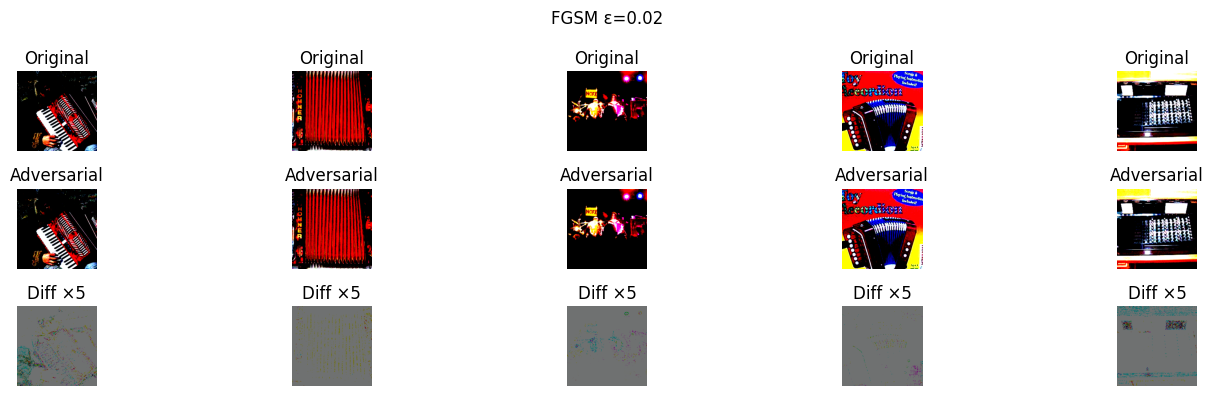

In [ ]:
show_adversarial_examples(test_loader, fgsm_adv_raw, title="FGSM ε=0.02")

In [ ]:
save_adversarial_images(fgsm_adv_raw, "AdversarialTestSet1", "fgsm")

In [ ]:
def pgd_attack_raw(model, images, labels, epsilon=0.02, steps=15):
    mean = torch.tensor(mean_norms).reshape(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std_norms).reshape(1, 3, 1, 1).to(images.device)

    raw = images * std + mean  # De-normalize
    adv = raw.clone().detach().requires_grad_(True)
    alpha = epsilon / steps

    for _ in range(steps):
        normalized = (adv - mean) / std
        outputs = model(normalized)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        adv.data = adv + alpha * adv.grad.sign()
        adv.data = torch.max(torch.min(adv, raw + epsilon), raw - epsilon)  # Project to ε-ball
        adv.data = torch.clamp(adv, 0, 1).detach()
        adv.requires_grad = True

    # Final normalized adversarial image
    adv_norm = (adv - mean) / std
    return adv_norm.detach()
pgd_adv = []
for images, labels in tqdm(test_loader, desc="PGD (Raw Space)"):
    images, labels = images.cuda(), labels.cuda()
    mapped_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
    adv_images = pgd_attack_raw(model, images, mapped_labels)
    pgd_adv.extend(adv_images.cpu())
evaluate_adv(model, pgd_adv, test_loader, imagenet_labels)

PGD (Raw Space): 100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


[ADV] Top-1: 0.00%, Top-5: 1.40%


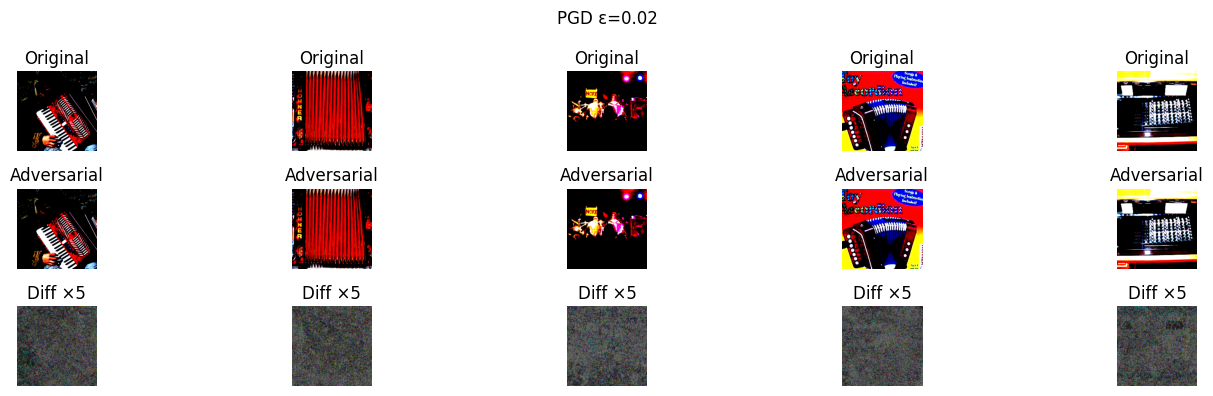

In [ ]:
show_adversarial_examples(test_loader, pgd_adv, title="PGD ε=0.02")

In [ ]:
save_adversarial_images(pgd_adv, "AdversarialTestSet2", "pgd")

In [ ]:
def patch_attack(model, images, labels, epsilon, steps=50, patch_size=48):
    alpha = epsilon / steps
    mean = torch.tensor(mean_norms).reshape(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std_norms).reshape(1, 3, 1, 1).to(images.device)

    raw = images * std + mean
    raw_orig = raw.clone().detach()

    _, _, H, W = raw.shape
    top = random.randint(0, H - patch_size)
    left = random.randint(0, W - patch_size)

    adv = raw.clone().detach()
    adv.requires_grad_()
    adv.retain_grad()

    for step in range(steps):
        norm_input = (adv - mean) / std
        outputs = model(norm_input)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward(retain_graph=True)

        grad = adv.grad
        grad_patch = grad[:, :, top:top+patch_size, left:left+patch_size]
        update = alpha * grad_patch.sign()

        patch = adv[:, :, top:top+patch_size, left:left+patch_size] + update
        orig_patch = raw_orig[:, :, top:top+patch_size, left:left+patch_size]

        clipped_patch = torch.clamp(patch, orig_patch - epsilon, orig_patch + epsilon)
        clipped_patch = torch.clamp(clipped_patch, 0, 1)

        # Replace the patch safely
        adv_new = adv.detach().clone()
        adv_new[:, :, top:top+patch_size, left:left+patch_size] = clipped_patch
        adv_new.requires_grad_()
        adv_new.retain_grad()
        adv = adv_new

        # Re-target patch region every 10 steps
        if (step + 1) % 10 == 0:
            top = random.randint(0, H - patch_size)
            left = random.randint(0, W - patch_size)

    return ((adv - mean) / std).detach()
def generate_patch_attacks(epsilon):
    patch_advs = []
    for images, labels in tqdm(test_loader, desc=f"Patch ε={epsilon}"):
        images = images.cuda()
        mapped_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
        adv = patch_attack(model, images, mapped_labels, epsilon=epsilon)
        patch_advs.extend(adv.cpu())
    return patch_advs
patch_adv_03 = generate_patch_attacks(0.3)
patch_adv_05 = generate_patch_attacks(0.5)

evaluate_adv(model, patch_adv_03, test_loader, imagenet_labels, label="Patch Attack ε=0.3")
evaluate_adv(model, patch_adv_05, test_loader, imagenet_labels, label="Patch Attack ε=0.5")

Patch ε=0.5: 100%|██████████| 16/16 [02:15<00:00,  8.47s/it]


[Patch Attack ε=0.3] Top-1: 0.20%, Top-5: 14.80%
[Patch Attack ε=0.5] Top-1: 0.00%, Top-5: 13.00%


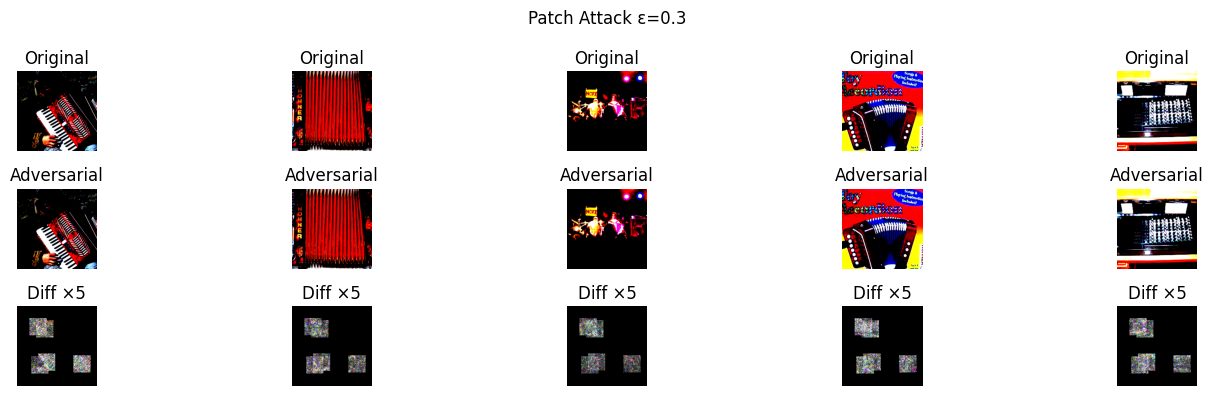

In [ ]:
show_adversarial_examples(test_loader, patch_adv_03, title="Patch Attack ε=0.3")

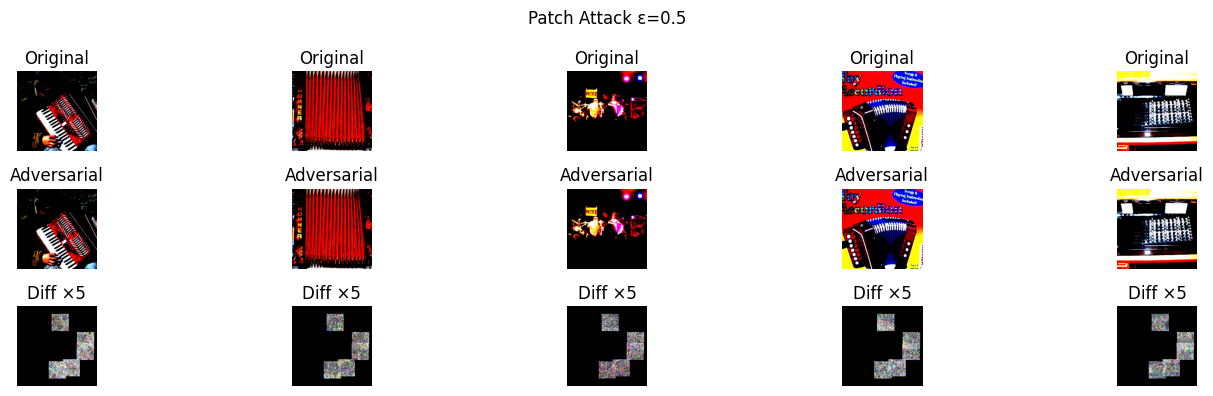

In [ ]:
show_adversarial_examples(test_loader, patch_adv_05, title="Patch Attack ε=0.5")

In [ ]:
save_adversarial_images(patch_adv_05, "AdversarialTestSet3", "patch")

In [ ]:
from torchvision.models import densenet121

densenet_model = densenet121(weights='IMAGENET1K_V1').cuda().eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 116MB/s]


In [ ]:
evaluate_adv(densenet_model, fgsm_adv_raw, test_loader, imagenet_labels, label="FGSM → DenseNet-121")
evaluate_adv(densenet_model, pgd_adv, test_loader, imagenet_labels, label="PGD → DenseNet-121")
evaluate_adv(densenet_model, patch_adv_03, test_loader, imagenet_labels, label="Patch Attack ε=0.3 → DenseNet-121")
evaluate_adv(densenet_model, patch_adv_05, test_loader, imagenet_labels, label="Patch Attack ε=0.5 → DenseNet-121")

[FGSM → DenseNet-121] Top-1: 45.60%, Top-5: 76.20%
[PGD → DenseNet-121] Top-1: 35.60%, Top-5: 72.40%
[Patch Attack ε=0.3 → DenseNet-121] Top-1: 58.80%, Top-5: 87.60%
[Patch Attack ε=0.5 → DenseNet-121] Top-1: 57.40%, Top-5: 85.40%


In [ ]:
!zip -r AdversarialTestSets.zip AdversarialTestSet1 AdversarialTestSet2 AdversarialTestSet3

  adding: AdversarialTestSet1/ (stored 0%)
  adding: AdversarialTestSet1/FGSM_422.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_115.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_210.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_163.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_150.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_288.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_309.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_419.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_049.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_039.png (deflated 1%)
  adding: AdversarialTestSet1/FGSM_478.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_433.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_305.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_247.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_071.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_381.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_332.png (d

In [ ]:
from google.colab import files
files.download("AdversarialTestSets.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

results = [
    {"Attack": "Clean", "Epsilon": "0", "Model": "ResNet-34", "Top-1": 76.00, "Top-5": 94.20},
    {"Attack": "FGSM", "Epsilon": "0.02", "Model": "ResNet-34", "Top-1": 3.40, "Top-5": 21.20},
    {"Attack": "PGD", "Epsilon": "0.02", "Model": "ResNet-34", "Top-1": 0.00, "Top-5": 1.40},
    {"Attack": "Patch", "Epsilon": "0.3", "Model": "ResNet-34", "Top-1": 0.20, "Top-5": 14.80},
    {"Attack": "Patch", "Epsilon": "0.5", "Model": "ResNet-34", "Top-1": 0.00, "Top-5": 13.00},

    {"Attack": "Clean", "Epsilon": "0", "Model": "DenseNet-121", "Top-1": 76.00, "Top-5": 94.20},
    {"Attack": "FGSM", "Epsilon": "0.02", "Model": "DenseNet-121", "Top-1": 45.60, "Top-5": 76.20},
    {"Attack": "PGD", "Epsilon": "0.02", "Model": "DenseNet-121", "Top-1": 35.60, "Top-5": 72.40},
    {"Attack": "Patch", "Epsilon": "0.3", "Model": "DenseNet-121", "Top-1": 58.80, "Top-5": 87.60},
    {"Attack": "Patch", "Epsilon": "0.5", "Model": "DenseNet-121", "Top-1": 57.40, "Top-5": 85.40},
]

df = pd.DataFrame(results)
df["AttackLabel"] = df["Attack"] + " ε=" + df["Epsilon"]
df.to_csv("final_results.csv", index=False)

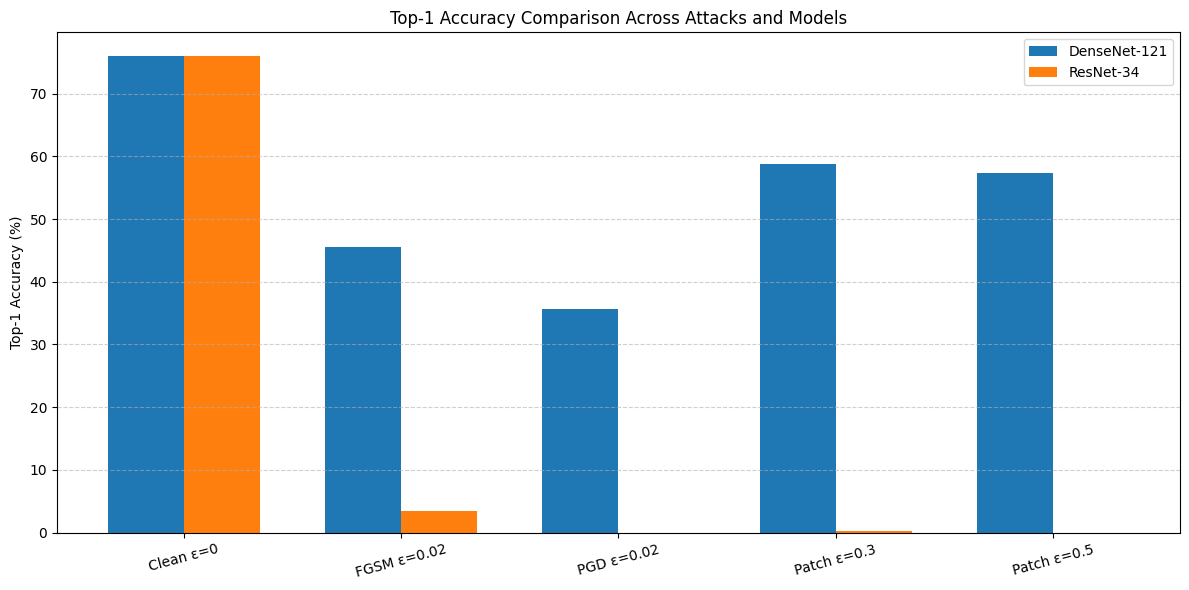

In [ ]:
import matplotlib.pyplot as plt

pivot = df.pivot(index="AttackLabel", columns="Model", values="Top-1").fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = range(len(pivot))

for i, model in enumerate(pivot.columns):
    ax.bar([p + i * bar_width for p in x], pivot[model], width=bar_width, label=model)

ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(pivot.index, rotation=15)
ax.set_ylabel("Top-1 Accuracy (%)")
ax.set_title("Top-1 Accuracy Comparison Across Attacks and Models")
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("final_accuracy_barplot.png")
plt.show()

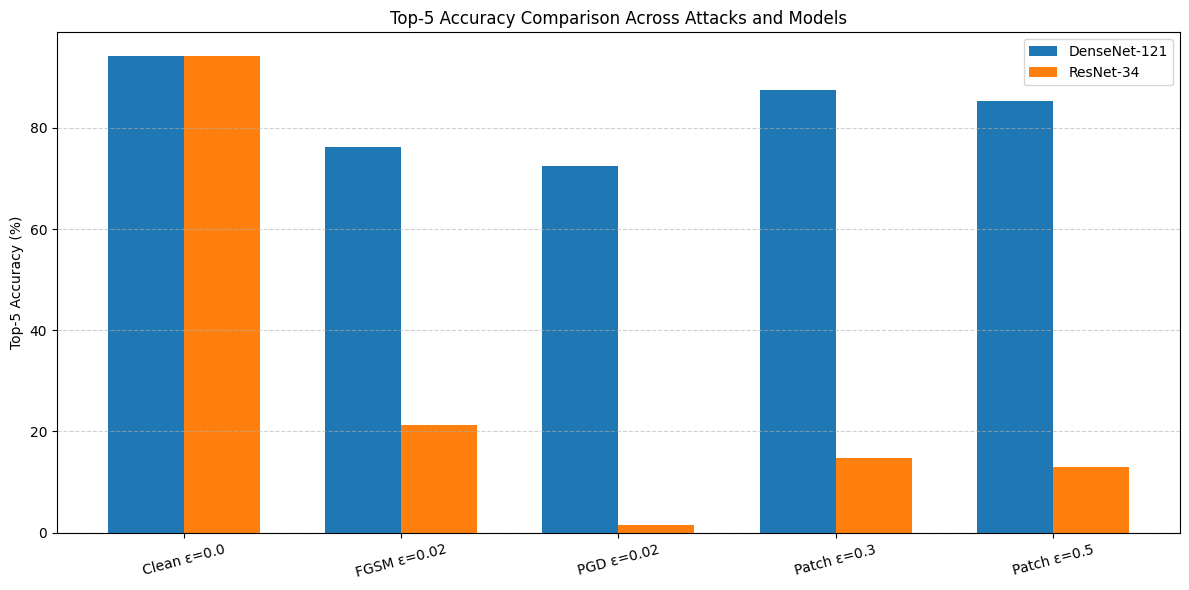

In [ ]:
import pandas as pd

df = pd.read_csv("final_results.csv")  # Replace with your path if different
df["AttackLabel"] = df["Attack"] + " ε=" + df["Epsilon"].astype(str)
import matplotlib.pyplot as plt

pivot_top5 = df.pivot(index="AttackLabel", columns="Model", values="Top-5").fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = range(len(pivot_top5))

for i, model in enumerate(pivot_top5.columns):
    ax.bar([p + i * bar_width for p in x], pivot_top5[model], width=bar_width, label=model)

ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(pivot_top5.index, rotation=15)
ax.set_ylabel("Top-5 Accuracy (%)")
ax.set_title("Top-5 Accuracy Comparison Across Attacks and Models")
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("final_top5_accuracy_barplot.png")
plt.show()

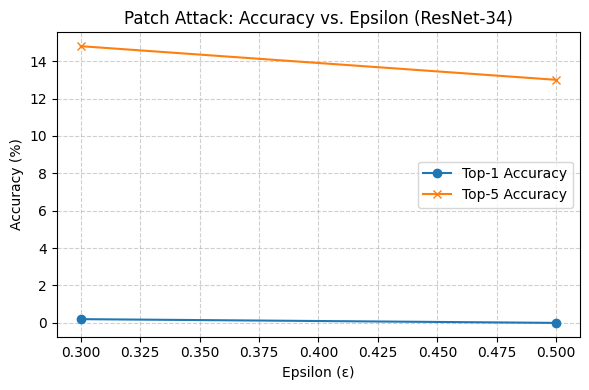

In [ ]:
patch_df = df[(df["Attack"] == "Patch") & (df["Model"] == "ResNet-34")]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(patch_df["Epsilon"].astype(float), patch_df["Top-1"], marker='o', label="Top-1 Accuracy")
ax.plot(patch_df["Epsilon"].astype(float), patch_df["Top-5"], marker='x', label="Top-5 Accuracy")

ax.set_xlabel("Epsilon (ε)")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Patch Attack: Accuracy vs. Epsilon (ResNet-34)")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("patch_accuracy_vs_epsilon.png")
plt.show()